<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Clean version

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. New loss function.
  - Using modulo and sigmoid
7. Modified R2 score
8. Gene normalization
9. Using original batch data.

TODO:
  - Reduce the bulk into smaller.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets
# path = Path('data/circadian')
path = Path('data')

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [4]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [5]:
loss_func = F.mse_loss

In [6]:
class TimeLayer(nn.Module):
    def __init__(self, range = 26):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [7]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
# metric = R2Score()

In [8]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [9]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

In [10]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)

In [11]:
raw_data.head()

,gene,AAACAGCCAACCCTAA-6,AAACCAACAGTAAAGC-6,AAACCGAAGGTCCTAG-6,AAAGCACCATTGTCCT-6,AAAGGACGTGAGGTGA-6,AAAGGAGCAAAGCGCA-6,AACAAAGGTAAAGCGG-6,AACAGATAGACTATTG-6,AACATAGCATGAGCAG-6,...,TTAGGATGTTTATCTG-7,TTATCCGTCACCTGCT-7,TTATTGCTCAAGTGTC-7,TTCCTTGAGTAAAGGT-7,TTCGTTAGTAACGAGG-7,TTGCCCGTCGCACAAT-7,TTGCGTCTCTTAGTCT-7,TTGGGTTAGCCACAAT-7,TTTAGCTTCAGGAAGC-7,TTTGGTAAGGAAGTAT-7
0,Meg3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Slc1a2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cyp2c40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cyp2c69,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
meta_data.head()

,cell_name,ZT
0,AAACAGCCAACCCTAA-6,ZT18
1,AAACCAACAGTAAAGC-6,ZT18
2,AAACCGAAGGTCCTAG-6,ZT18
3,AAAGCACCATTGTCCT-6,ZT18
4,AAAGGACGTGAGGTGA-6,ZT18


In [13]:
data = raw_data.set_index('gene').T
cell_sums = data.sum(axis=1)
cell_divided = data.div(cell_sums, axis=0)
nrm = (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)
data = nrm
df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
data2 = data.join(df_mis)
df = data2.join(meta_data.set_index('cell_name'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

In [14]:
batch_ct = pd.read_csv(path/'sc_RNA_ct.csv', low_memory=False)
batch_zt = pd.read_csv(path/'sc_RNA_ZT.csv', low_memory=False)
batch_ct.head()

,Unnamed: 0,AAACAGCCAGCAATAA.8,AAACGCGCAGTATGTT.8,AAAGCGGGTGCATCGG.8,AAAGGACGTAAGGTTT.8,AAAGGAGCAACCGCCA.8,AACCCGCAGGCCAATT.8,AACCCGCAGTCATTAG.8,AACTAGCTCGTACCGA.8,AACTAGCTCTGTAAGC.8,...,CTCCCTGAGAGCCGCT.2,CTTGCATGTAAGGTCC.2,GCTAAGTTCTAAGTGC.2,GCTCACAAGCTGGACC.2,GCTGCACAGTAGCGGG.2,GTCCAAGTCTACTAAG.2,TACCGTTGTTACGCAA.2,TCCATCATCAGGTTTA.2,TCGTTAGCAGTAGGAT.2,TGAACAGAGTGATTCA.2
0,Xkr4,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1,Rp1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Sox17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mrpl15,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,Lypla1,1,4,0,0,2,6,2,5,0,...,0,0,0,2,0,0,1,1,0,0


In [15]:
batch_ct.iloc[:,0]

0           Xkr4
1            Rp1
2          Sox17
3         Mrpl15
4         Lypla1
          ...   
16363    mt-Nd4l
16364     mt-Nd4
16365     mt-Nd5
16366     mt-Nd6
16367    mt-Cytb
Name: Unnamed: 0, Length: 16368, dtype: object

In [16]:
batch_zt.head()

,Unnamed: 0,ZT
0,AAACAGCCAGCAATAA-8,ZT18
1,AAACGCGCAGTATGTT-8,ZT18
2,AAAGCGGGTGCATCGG-8,ZT18
3,AAAGGACGTAAGGTTT-8,ZT18
4,AAAGGAGCAACCGCCA-8,ZT18


In [17]:
raw_data = batch_ct
raw_data.columns = raw_data.columns.str.replace('.', '-')
meta_data = batch_zt

data = raw_data.set_index('Unnamed: 0').T
cell_sums = data.sum(axis=1)
cell_divided = data.div(cell_sums, axis=0)
nrm = (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)
data = nrm
# df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
# data2 = data.join(df_mis)
df = data.join(meta_data.set_index('Unnamed: 0'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

In [18]:
df.head()

,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,4732440D04Rik,...,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,ZT,code
AAACAGCCAGCAATAA-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.363687,-0.633744,-0.048407,-0.626202,-0.174223,-0.312544,...,-0.368729,-0.094769,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.000030,ZT18,18.0
AAACGCGCAGTATGTT-8,-0.049673,-0.04268,-0.124963,-0.489307,2.078659,-0.633744,-0.048407,-0.626202,1.304845,-0.312544,...,-0.190708,-0.086019,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213,ZT18,18.0
AAAGCGGGTGCATCGG-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,0.477558,-0.168903,-0.312544,...,-0.264324,-0.092338,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213,ZT18,18.0
AAAGGACGTAAGGTTT-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,0.512518,-0.312544,...,-0.286073,0.218951,-0.293294,-0.212751,-0.432418,1.039197,-0.118702,-0.041078,ZT18,18.0
AAAGGAGCAACCGCCA-8,-0.049673,-0.04268,-0.124963,-0.489307,1.023501,-0.633744,-0.048407,-0.626202,0.480769,-0.312544,...,-0.107936,-0.140863,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.048753,ZT18,18.0


### Bulk + scRNA-seq

In [19]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [20]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [21]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [22]:
bulk_data = raw_bulk_data.set_index('ID').T
bulk_data = (bulk_data - bulk_data.mean(axis=0)) / bulk_data.std(axis=0)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [23]:
bulk_data.head()

ID,2810459M11Rik,Abcb11,Acot7,Ahctf1,Ap2a2,Asb13,Asl,Chka,Clic3,Clpx,...,Ap1s3,Vamp4,Pigm,Pard6g,Gas2,Pot1b,Zfp759,Neo1,Sco1,code
ZT2_1,1.105385,1.734929,-1.000468,-0.675204,0.840018,0.483757,-1.549016,0.124098,-0.232362,0.848045,...,2.752890,-0.473227,1.929628,0.128575,-0.790649,-0.444183,0.143286,-0.561441,-0.562906,2
ZT6_1,0.140685,0.362813,0.216831,-1.176028,-0.819429,-0.259607,-0.637751,-1.136919,-0.522711,-1.026734,...,-0.789960,0.250906,-0.690604,0.128575,0.738327,-1.036427,-1.197874,1.199442,0.094325,6
ZT10_1,-0.816706,-1.059483,0.376602,-0.640493,-1.968277,-1.844144,0.759326,-1.019758,-0.540232,-1.165550,...,0.215444,0.250906,-0.243742,-1.651693,-0.302307,-0.049354,1.828333,-1.939524,-1.767828,10
ZT14_1,-0.746059,-0.951535,1.700414,0.762807,-0.123532,-0.425885,0.793645,-0.165720,-0.294937,-0.431148,...,0.550578,1.622947,0.487485,0.959366,0.023254,-0.049354,-0.647654,1.429123,1.372273,14
ZT18_1,0.250310,-0.396195,0.361386,1.328094,0.432362,0.625583,0.991523,0.580407,0.012932,1.159798,...,-0.406949,-1.197360,0.934346,-0.108794,1.197601,0.740305,0.074509,-0.178640,0.422940,18


In [24]:
gro = raw_gro.set_index('ID').T
nascent = raw_nascent.set_index('ID').T
gro = (gro - gro.mean(axis=0)) / gro.std(axis=0)
nascent = (nascent - nascent.mean(axis=0)) / nascent.std(axis=0)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

Since new batch data is bigger, we gotta change shapes.

In [74]:
column_intersections = df.columns.intersection(bulk_data.columns)
column_intersections

Index(['Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1', 'Pcmtd1',
       'Rrs1', 'Adhfe1', 'Mybl1',
       ...
       'Afap1l2', 'Trub1', 'Hspa12a', 'Slc18a2', 'Pdzd8', 'Rab11fip2', 'Sfxn4',
       'Prdx3', 'Csf2ra', 'code'],
      dtype='object', length=9335)

In [75]:
df = df.loc[:,column_intersections]
df

,Sox17,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Adhfe1,Mybl1,...,Afap1l2,Trub1,Hspa12a,Slc18a2,Pdzd8,Rab11fip2,Sfxn4,Prdx3,Csf2ra,code
AAACAGCCAGCAATAA-8,-0.124963,-0.489307,-0.363687,-0.633744,-0.626202,-0.174223,1.181735,-0.307267,-0.287939,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,18.0
AAACGCGCAGTATGTT-8,-0.124963,-0.489307,2.078659,-0.633744,-0.626202,1.304845,0.364943,2.984634,0.723687,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,18.0
AAAGCGGGTGCATCGG-8,-0.124963,-0.489307,-0.912213,-0.633744,0.477558,-0.168903,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,18.0
AAAGGACGTAAGGTTT-8,-0.124963,-0.489307,-0.912213,-0.633744,-0.626202,0.512518,0.349555,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,0.930811,-0.404423,-0.091748,-0.334582,-0.080832,18.0
AAAGGAGCAACCGCCA-8,-0.124963,-0.489307,1.023501,-0.633744,-0.626202,0.480769,1.445405,-0.307267,0.160050,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCCAAGTCTACTAAG-2,-0.124963,-0.489307,-0.912213,-0.633744,-0.626202,-1.031017,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,6.0
TACCGTTGTTACGCAA-2,-0.124963,-0.489307,0.426962,-0.633744,-0.626202,-1.031017,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,6.0
TCCATCATCAGGTTTA-2,-0.124963,-0.489307,0.745681,1.589905,-0.626202,-1.031017,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,6.0
TCGTTAGCAGTAGGAT-2,-0.124963,-0.489307,-0.912213,-0.633744,-0.626202,-1.031017,-1.383329,-0.307267,-0.873954,-0.112713,...,-0.107669,-0.51434,-0.126079,-0.184373,-0.561123,-0.404423,-0.091748,-0.334582,-0.080832,6.0


In [27]:
# bulk_genes_set = set(raw_bulk_data['ID'])
# sc_genes = raw_data['gene']

In [28]:
# genes = [gene for gene in sc_genes if gene in bulk_genes_set]

In [29]:
# mis_genes = [gene for gene in sc_genes if gene not in bulk_genes_set]

In [96]:
def make_df(dataset):
    return dataset.loc[:,column_intersections]

In [97]:
nascent_df = make_df(nascent)
gro_df = make_df(gro)
rna_df = make_df(bulk_data)

## Using Pytorch

In [99]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-1]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_14860/705046130.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.float)


In [100]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [101]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [102]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([20855, 1]), torch.Size([5213, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [103]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 9334]), torch.Size([128, 1]))

In [104]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [105]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl}

/tmp/ipykernel_14860/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_14860/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_14860/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)


Changing the metric to R2Score.

In [107]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [108]:
len(indep_cols)

9334

In [109]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [110]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [111]:
get_model()(xb).shape

torch.Size([128, 1])

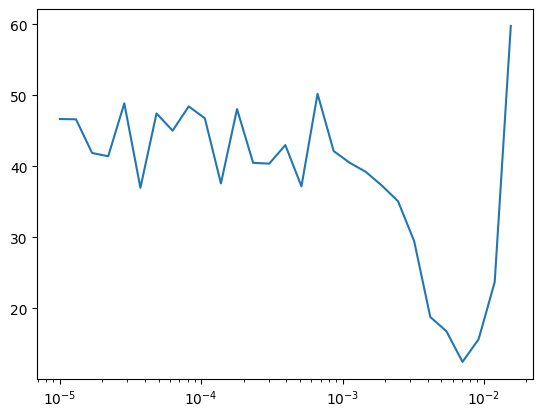

In [112]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.261,32.848,0,True,00:01
0.575,18.705,0,False,00:00
0.747,11.250,1,True,00:01
0.784,9.522,1,False,00:00
0.868,5.860,2,True,00:01
0.823,7.848,2,False,00:00
0.914,3.815,3,True,00:01
0.835,7.349,3,False,00:00
0.940,2.685,4,True,00:01
0.840,7.151,4,False,00:00


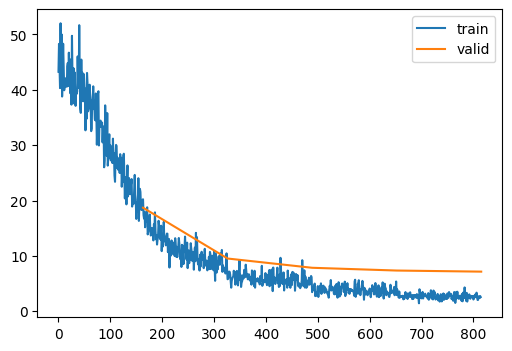

In [120]:
lr, epochs = 1e-4, 5
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [114]:
from functools import partial

In [115]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [116]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        print('result: ', metric.compute())

In [117]:
nlearn = 2

Training models


TimeR2Score,loss,epoch,train,time
0.761,10.817,0,True,00:01
0.848,6.827,0,False,00:00
0.953,2.080,1,True,00:01
0.868,5.942,1,False,00:00


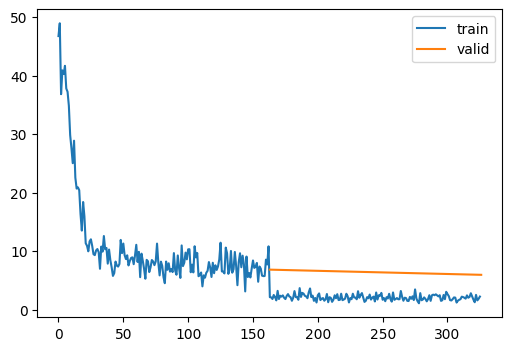

TimeR2Score,loss,epoch,train,time
0.752,11.152,0,True,00:01
0.853,6.563,0,False,00:00
0.952,2.140,1,True,00:01
0.861,6.324,1,False,00:00


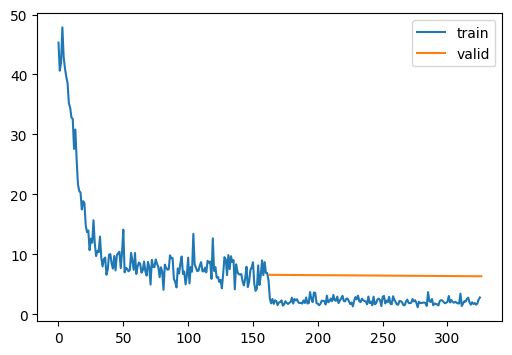

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.229,36.722,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.087,44.859,0,False,00:00


Inference on nascent
		preds, targs
tensor([[10.2460,  0.0000],
        [ 1.5146,  4.0000],
        [10.1074,  8.0000],
        [ 5.2526, 12.0000],
        [ 9.0675, 16.0000],
        [24.1593, 20.0000],
        [ 5.0881,  0.0000],
        [-0.4074,  4.0000],
        [20.3729,  8.0000],
        [ 9.4198, 12.0000],
        [21.3037, 16.0000],
        [24.7758, 20.0000]])
result:  tensor(0.1704)


TimeR2Score,loss,epoch,train,time
0.493,29.771,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.537,31.824,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 3.4338,  1.0000],
        [ 2.5712,  4.0000],
        [ 3.3750,  7.0000],
        [ 8.6491, 10.0000],
        [16.6632, 13.0000],
        [ 2.6876, 16.0000],
        [24.1703, 19.0000],
        [24.2917, 22.0000]])
result:  tensor(0.5170)


TimeR2Score,loss,epoch,train,time
0.563,36.314,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.389,31.621,0,False,00:00


Inference on rna
		preds, targs
tensor([[11.0565,  2.0000],
        [ 4.7476,  6.0000],
        [ 8.0614, 10.0000],
        [14.4391, 14.0000],
        [24.2485, 18.0000],
        [24.2784, 22.0000],
        [ 3.0053,  2.0000],
        [ 9.5122,  6.0000],
        [11.0600, 10.0000],
        [10.5167, 14.0000],
        [11.8169, 18.0000],
        [ 7.6209, 22.0000]])
result:  tensor(0.4836)


In [118]:
ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [121]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [122]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

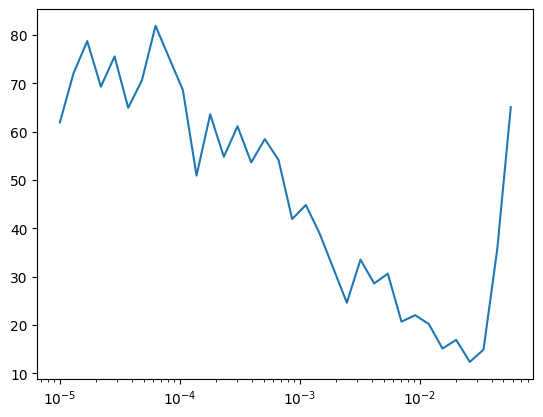

In [123]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.772,10.713,0,True,00:01
0.830,7.860,0,False,00:00
0.870,5.958,1,True,00:01
0.863,6.305,1,False,00:00
0.922,3.489,2,True,00:01
0.879,5.598,2,False,00:00
0.962,1.699,3,True,00:01
0.885,5.352,3,False,00:00


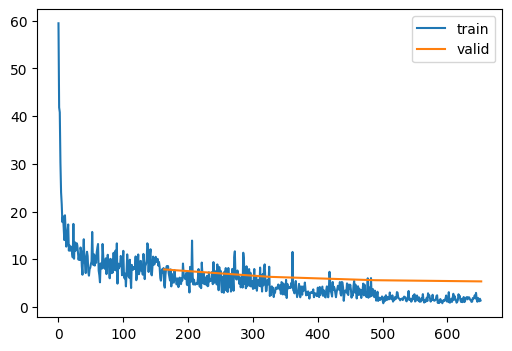

TimeR2Score,loss,epoch,train,time
0.773,10.803,0,True,00:01
0.836,7.646,0,False,00:00
0.866,6.195,1,True,00:01
0.860,6.344,1,False,00:00
0.928,3.226,2,True,00:01
0.876,5.786,2,False,00:00
0.960,1.786,3,True,00:02
0.884,5.437,3,False,00:00


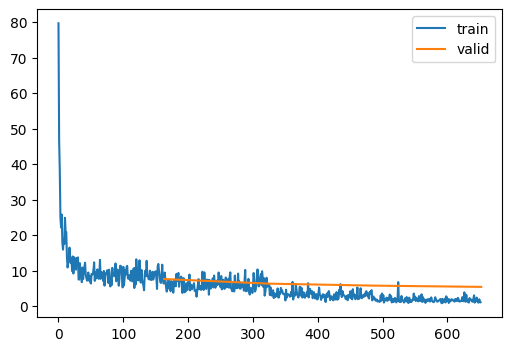

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.541,21.438,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.537,21.616,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 6.5009,  0.0000],
        [ 3.1120,  4.0000],
        [ 9.4197,  8.0000],
        [ 5.6903, 12.0000],
        [ 7.3971, 16.0000],
        [22.5588, 20.0000],
        [ 2.7008,  0.0000],
        [ 2.1379,  4.0000],
        [14.5311,  8.0000],
        [ 9.1939, 12.0000],
        [11.4122, 16.0000],
        [22.7225, 20.0000]])
result:  tensor(0.5443)


TimeR2Score,loss,epoch,train,time
0.755,11.569,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.868,6.228,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 1.9517,  1.0000],
        [ 7.5060,  4.0000],
        [ 6.4246,  7.0000],
        [ 9.5370, 10.0000],
        [14.3425, 13.0000],
        [ 9.3993, 16.0000],
        [20.9086, 19.0000],
        [23.0879, 22.0000]])
result:  tensor(0.8308)


TimeR2Score,loss,epoch,train,time
0.339,41.893,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.417,43.009,0,False,00:00


Inference on rna
		preds, targs
tensor([[10.4264,  2.0000],
        [ 6.1062,  6.0000],
        [ 9.8749, 10.0000],
        [14.9342, 14.0000],
        [23.6645, 18.0000],
        [20.0488, 22.0000],
        [ 1.1966,  2.0000],
        [ 9.3825,  6.0000],
        [11.0818, 10.0000],
        [10.8207, 14.0000],
        [ 5.6778, 18.0000],
        [ 7.0622, 22.0000]])
result:  tensor(0.3756)


In [124]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.784,10.349,0,True,00:02
0.848,7.547,0,False,00:00
0.888,5.153,1,True,00:02
0.864,6.345,1,False,00:00
0.942,2.599,2,True,00:02
0.888,5.217,2,False,00:00
0.968,1.409,3,True,00:02
0.893,4.962,3,False,00:00


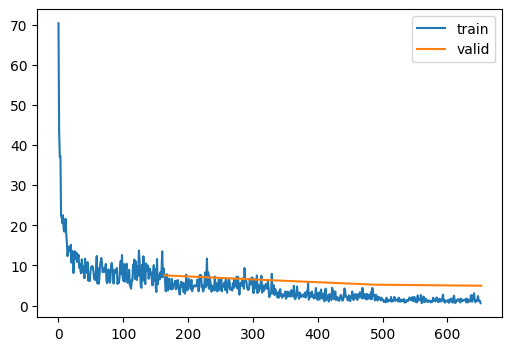

TimeR2Score,loss,epoch,train,time
0.778,10.503,0,True,00:02
0.841,7.144,0,False,00:00
0.881,5.486,1,True,00:02
0.872,5.774,1,False,00:00
0.944,2.499,2,True,00:02
0.886,5.262,2,False,00:00
0.966,1.525,3,True,00:02
0.890,5.128,3,False,00:00


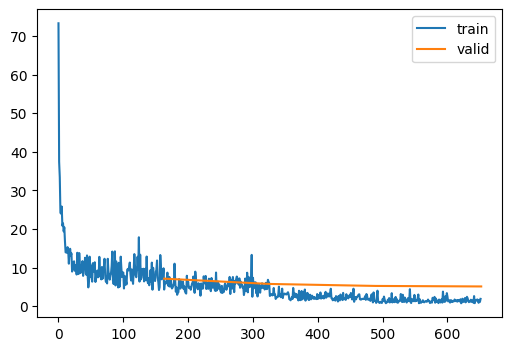

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.734,12.414,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.625,17.493,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 4.5379,  0.0000],
        [ 3.0854,  4.0000],
        [ 9.2067,  8.0000],
        [ 6.4160, 12.0000],
        [ 9.4080, 16.0000],
        [21.9996, 20.0000],
        [ 2.3996,  0.0000],
        [ 1.8199,  4.0000],
        [13.7482,  8.0000],
        [ 8.8704, 12.0000],
        [12.3024, 16.0000],
        [22.6023, 20.0000]])
result:  tensor(0.6869)


TimeR2Score,loss,epoch,train,time
0.808,9.076,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.802,9.370,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 1.2408,  1.0000],
        [ 4.2615,  4.0000],
        [ 5.7292,  7.0000],
        [ 9.1615, 10.0000],
        [13.5096, 13.0000],
        [ 8.1042, 16.0000],
        [20.9857, 19.0000],
        [23.2144, 22.0000]])
result:  tensor(0.8136)


TimeR2Score,loss,epoch,train,time
0.350,46.213,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.348,30.446,0,False,00:00


Inference on rna
		preds, targs
tensor([[11.0260,  2.0000],
        [ 5.5424,  6.0000],
        [ 9.7756, 10.0000],
        [14.8735, 14.0000],
        [23.6069, 18.0000],
        [21.1973, 22.0000],
        [ 1.1088,  2.0000],
        [ 9.5126,  6.0000],
        [10.2586, 10.0000],
        [10.8357, 14.0000],
        [ 6.3151, 18.0000],
        [ 8.9000, 22.0000]])
result:  tensor(0.2980)


In [125]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.772,10.814,0,True,00:02
0.798,10.124,0,False,00:00
0.850,6.919,1,True,00:02
0.841,7.116,1,False,00:00
0.895,4.764,2,True,00:02
0.864,6.368,2,False,00:00
0.941,2.623,3,True,00:02
0.876,5.891,3,False,00:00
0.966,1.519,4,True,00:02
0.881,5.517,4,False,00:00


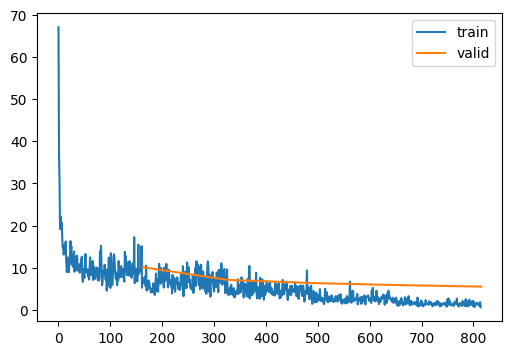

TimeR2Score,loss,epoch,train,time
0.771,10.790,0,True,00:02
0.848,6.760,0,False,00:00
0.855,6.698,1,True,00:02
0.855,6.567,1,False,00:00
0.896,4.720,2,True,00:02
0.873,5.940,2,False,00:00
0.941,2.636,3,True,00:02
0.885,5.392,3,False,00:00
0.966,1.532,4,True,00:02
0.889,5.188,4,False,00:00


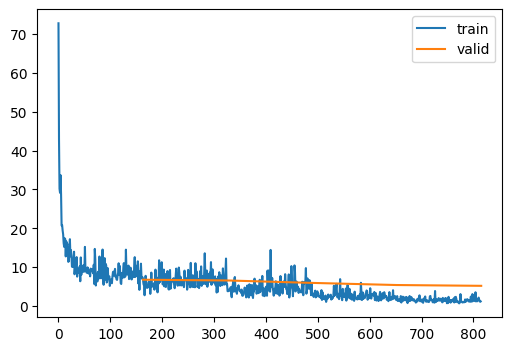

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.679,14.972,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.708,13.646,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.9903,  0.0000],
        [ 3.1797,  4.0000],
        [ 9.4940,  8.0000],
        [ 6.6665, 12.0000],
        [ 8.3033, 16.0000],
        [22.0144, 20.0000],
        [ 1.6386,  0.0000],
        [ 2.0829,  4.0000],
        [12.0714,  8.0000],
        [ 9.3809, 12.0000],
        [11.1433, 16.0000],
        [22.5603, 20.0000]])
result:  tensor(0.7080)


TimeR2Score,loss,epoch,train,time
0.779,10.430,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.556,20.971,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.6923,  1.0000],
        [ 7.8061,  4.0000],
        [ 5.9992,  7.0000],
        [ 9.2823, 10.0000],
        [13.4710, 13.0000],
        [ 6.3794, 16.0000],
        [21.5202, 19.0000],
        [22.7649, 22.0000]])
result:  tensor(0.6863)


TimeR2Score,loss,epoch,train,time
0.406,35.173,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.484,66.876,0,False,00:00


Inference on rna
		preds, targs
tensor([[13.2244,  2.0000],
        [ 5.0448,  6.0000],
        [ 9.4576, 10.0000],
        [14.9728, 14.0000],
        [23.8336, 18.0000],
        [20.8385, 22.0000],
        [ 1.2992,  2.0000],
        [ 9.5225,  6.0000],
        [10.2386, 10.0000],
        [ 9.8179, 14.0000],
        [ 3.6833, 18.0000],
        [ 8.4044, 22.0000]])
result:  tensor(0.2929)


In [126]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.783,10.298,0,True,00:02
0.867,5.963,0,False,00:00
0.882,5.370,1,True,00:02
0.861,6.448,1,False,00:00
0.930,3.117,2,True,00:02
0.891,5.337,2,False,00:00
0.955,1.994,3,True,00:02
0.898,4.917,3,False,00:00
0.970,1.327,4,True,00:02
0.903,4.540,4,False,00:00


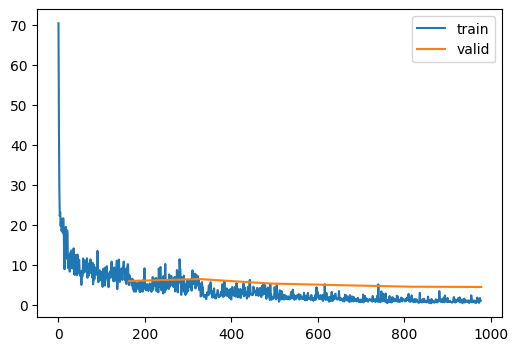

TimeR2Score,loss,epoch,train,time
0.774,10.678,0,True,00:02
0.860,6.296,0,False,00:00
0.877,5.615,1,True,00:02
0.866,6.374,1,False,00:00
0.924,3.427,2,True,00:02
0.881,5.516,2,False,00:00
0.953,2.112,3,True,00:02
0.892,5.076,3,False,00:00
0.972,1.254,4,True,00:02
0.896,4.814,4,False,00:00


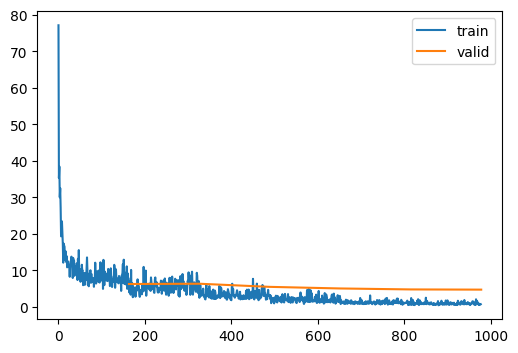

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.696,14.195,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.712,13.418,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 4.0199,  0.0000],
        [ 3.8027,  4.0000],
        [ 8.5305,  8.0000],
        [ 6.5524, 12.0000],
        [ 9.9348, 16.0000],
        [22.2817, 20.0000],
        [ 2.2123,  0.0000],
        [ 2.2010,  4.0000],
        [12.7633,  8.0000],
        [ 9.4465, 12.0000],
        [10.6239, 16.0000],
        [22.8240, 20.0000]])
result:  tensor(0.7101)


TimeR2Score,loss,epoch,train,time
0.760,11.344,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.810,8.994,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 0.2794,  1.0000],
        [ 4.9982,  4.0000],
        [ 6.4321,  7.0000],
        [ 9.4234, 10.0000],
        [12.9862, 13.0000],
        [ 7.5116, 16.0000],
        [20.8299, 19.0000],
        [23.0524, 22.0000]])
result:  tensor(0.7919)


TimeR2Score,loss,epoch,train,time
0.479,55.952,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.364,32.351,0,False,00:00


Inference on rna
		preds, targs
tensor([[10.8929,  2.0000],
        [ 5.9516,  6.0000],
        [10.0177, 10.0000],
        [14.4908, 14.0000],
        [23.8257, 18.0000],
        [20.7106, 22.0000],
        [ 1.4799,  2.0000],
        [ 8.4425,  6.0000],
        [10.0957, 10.0000],
        [10.4853, 14.0000],
        [ 5.2929, 18.0000],
        [ 7.0400, 22.0000]])
result:  tensor(0.3879)


In [127]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.